In [7]:
import pandas as pd
import numpy as np
#pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

#PLOT & MATH LIBS
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as st
import matplotlib.pyplot as plt

In [8]:
UPDRS3 = "data/MDS-UPDRS_Part_III_10Jun2024.csv"
patient_status = "data/Participant_Status_03Jun2024.csv"

df3 = pd.read_csv(UPDRS3)
df_pat_stat = pd.read_csv(patient_status) #patient status data
df3 = df3.dropna(subset=['NP3TOT']).reset_index() # will keep for now, might need to include nans
df3['INFODT'] = pd.to_datetime(df3['INFODT'], format="%m/%Y") #reformat INFODT (Assesment Date) to date-time objects
df3['PDSTATE'] =  df3['PDSTATE'].fillna(0)
df3 = df3[["PATNO", "EVENT_ID", "INFODT", "PDSTATE", "PAG_NAME", "NP3TOT"]]

desired_cols_df_pat = {'PATNO', 'COHORT', 'ENROLL_STATUS', 'ENROLL_AGE'}
pat_filtered = df_pat_stat.drop(columns=set(df_pat_stat.columns) - desired_cols_df_pat)

### Pair up and filter
- need states to be the same: NaN - NaN, ON-ON, OFF-OFF
- Event ID's lexigraphically sorted, x < y
- Dates less than or equal (while Event ID's sorted)

In [9]:
df3_pairs = df3.merge(df3, how="outer", on="PATNO")

df3_filter = (
    (df3_pairs['PDSTATE_x'] == df3_pairs['PDSTATE_y'])
    & (
        (df3_pairs['INFODT_x'] < df3_pairs['INFODT_y'])
        | ((df3_pairs['INFODT_x'] == df3_pairs['INFODT_y'])
           & (df3_pairs['EVENT_ID_x'] < df3_pairs['EVENT_ID_y']))
    )
)

df3_pairs = df3_pairs[df3_filter]
df3_full = pd.merge(df3_pairs, pat_filtered, on="PATNO")
df3_full = df3_full[df3_full['ENROLL_STATUS'].isin(['Enrolled', 'Withdrew', 'Complete'])]


df3_full['delta_UPDRS'] = (df3_full['NP3TOT_y'] - df3_full['NP3TOT_x']) / ((df3_full['INFODT_y'] - df3_full['INFODT_x']).dt.days / 365)
df3_full['abs_delta_UPDRS'] = (df3_full['NP3TOT_y'] - df3_full['NP3TOT_x'])

In [12]:
df3_full.head(10)

PATNO EVENT_ID_x   INFODT_x PDSTATE_x PAG_NAME_x  NP3TOT_x EVENT_ID_y  \
0   3000         BL 2011-02-01         0    NUPDRS3       4.0        V04   
1   3000         BL 2011-02-01         0    NUPDRS3       4.0        V06   
2   3000         BL 2011-02-01         0    NUPDRS3       4.0        V08   
3   3000         BL 2011-02-01         0    NUPDRS3       4.0        V10   
4   3000         BL 2011-02-01         0    NUPDRS3       4.0        V12   
5   3000         BL 2011-02-01         0    NUPDRS3       4.0        V14   
6   3000         BL 2011-02-01         0    NUPDRS3       4.0        V15   
7   3000         BL 2011-02-01         0    NUPDRS3       4.0        V17   
8   3000        V04 2012-03-01         0    NUPDRS3       1.0        V06   
9   3000        V04 2012-03-01         0    NUPDRS3       1.0        V08   

    INFODT_y PDSTATE_y  PAG_NAME_y  NP3TOT_y  COHORT ENROLL_STATUS  \
0 2012-03-01         0     NUPDRS3       1.0       2      Enrolled   
1 2013-02-01         0     NUPDRS3       4.0       2      Enrolled   
2 2014-03-01         0     NUPDRS3       2.0       2      Enrolled   
3 2015-03-01         0     NUPDRS3      19.0       2      Enrolled   
4 2016-04-01         0     NUPDRS3       3.0       2      Enrolled   
5 2018-02-01         0     NUPDRS3      10.0       2      Enrolled   
6 2019-03-01         0     NUPDRS3       5.0       2      Enrolled   
7 2021-05-01         0  NUPDRDOSE3       3.0       2      Enrolled   
8 2013-02-01         0     NUPDRS3       4.0       2      Enrolled   
9 2014-03-01         0     NUPDRS3       2.0       2      Enrolled   

   ENROLL_AGE  delta_UPDRS  abs_delta_UPDRS  
0        69.1    -2.779188             -3.0  
1        69.1     0.000000              0.0  
2        69.1    -0.649466             -2.0  
3        69.1     3.676964             15.0  
4        69.1    -0.193531             -1.0  
5        69.1     0.856472              6.0  
6        69.1     0.123729              1.0  
7        69.1    -0.097541             -1.0  
8        69.1     3.249258              3.0  
9        69.1     0.500000              1.0

In [17]:
df3_full_filtered = df3_full[~(df3_full['delta_UPDRS'].isin([np.infty, -np.infty])) & ~(df3_full['delta_UPDRS'].isna())]

df3_error_proxy = df3_full[(df3_full['delta_UPDRS'].isin([np.infty, -np.infty])) | (df3_full['delta_UPDRS'].isna())]
df3_error_proxy['delta_UPDRS_error'] =  df3_error_proxy['NP3TOT_y'] - df3_error_proxy['NP3TOT_x']

### Using Two different tests in same month as Measurement Error (PD Patients Only)


**REDO ON PATINETS ONLY, SANS CONTROLS**

Standard Measurment Error: 3.5052605390765157

Histogram of Delta UPDRS for same month visits


<Axes: >

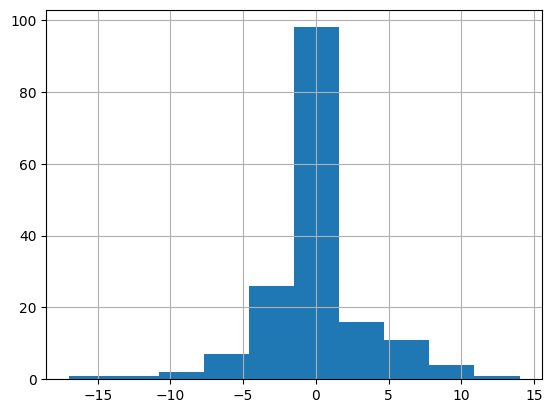

In [18]:
print(f"Standard Measurment Error: {np.std(df3_error_proxy['delta_UPDRS_error'])}")
print("\nHistogram of Delta UPDRS for same month visits")
df3_error_proxy['delta_UPDRS_error'].hist()

#### Normal Distribution Test for Error Proxy
- H0: Data was produced from Normal Distribution with mean = 0
- H1: Data was not produced from Normal Distribution
- Confidence level = 0.05 (on the conservative side)

**Result: H0 rejected -> Not Normal at the 95% CL**

Note: Would even fail to reject at 99% CL, but the distribution shows both symmedtry and the mean = 0 tendency. 

In [19]:
print(st.normaltest(df3_error_proxy['delta_UPDRS_error']))
error_mean = np.mean(df3_error_proxy['delta_UPDRS_error'])
error_std = np.std(df3_error_proxy['delta_UPDRS_error'])

NormaltestResult(statistic=30.219177698245403, pvalue=2.741504347950217e-07)


**Fitting Normal Distribution to sample error data**

In [8]:
norm_dist = st.norm
bounds = [(-100,100), (-100,100)]
fit_result = st.fit(norm_dist, df3_error_proxy['delta_UPDRS_error'], bounds)

print(f"Fitted Params: mean = {fit_result.params[0]}, std = {fit_result.params[1]}")
print(f"Sample: mean = {error_mean}, std = {error_std}")

Fitted Params: mean = 0.023952451359321333, std = 3.505261011792583
Sample: mean = 0.023952095808383235, std = 3.5052605390765157


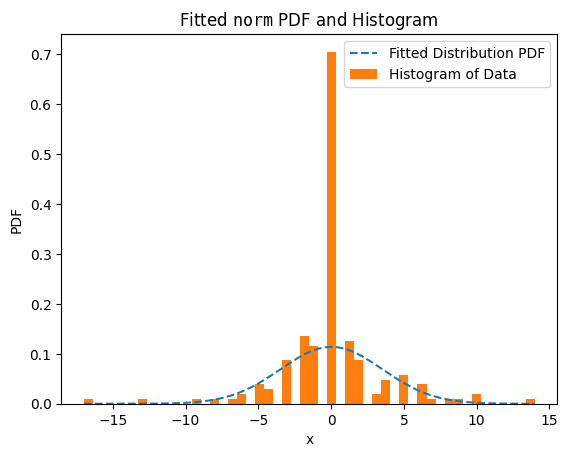

In [9]:
fit_result.plot()
plt.show()

### Cohort Distributions

In [10]:
controls = df3_full_filtered[df3_full_filtered['COHORT'] == 2]
PD_total = df3_full_filtered[df3_full_filtered['COHORT'] == 1]
PD_on = PD_total[(PD_total['PDSTATE_x'] == "ON") & (PD_total['PAG_NAME_x'] != 'NUPDR3OFF')]
PD_off = PD_total[(PD_total['PDSTATE_x'] == "OFF") & (PD_total['PAG_NAME_x'] != 'NUPDR3ON')]
PD_off_nan = PD_total[PD_total['PDSTATE_x'] != "ON"]
PD_nan = PD_total[(PD_total['PDSTATE_x'] != 'ON') & (PD_total['PDSTATE_x'] != 'OFF') & (PD_total['PAG_NAME_x'] != 'NUPDR3OF') & (PD_total['PAG_NAME_x'] != 'NUPDR3ON')]

mean_control = np.mean(controls['delta_UPDRS'])
mean_on = np.mean(PD_on['delta_UPDRS'])
mean_off = np.mean(PD_off['delta_UPDRS']) 
mean_off_nan = np.mean(PD_off_nan['delta_UPDRS'])

med_control = np.median(controls['delta_UPDRS'])
med_on = np.median(PD_on['delta_UPDRS'])
med_off = np.median(PD_off['delta_UPDRS'])
med_off_nan = np.median(PD_off_nan['delta_UPDRS'])

std_control = np.std(controls['delta_UPDRS'])
std_on = np.std(PD_on['delta_UPDRS'])
std_off = np.std(PD_off['delta_UPDRS'])
std_off_nan = np.std(PD_off_nan['delta_UPDRS'])

In [15]:
std_control

1.7552523909764544

In [237]:
# ON vs OFF states
hist1 = go.Histogram(
    x= PD_on['delta_UPDRS'],
    name='ON',
    opacity=0.80
)

hist2 = go.Histogram(
    x= PD_off['delta_UPDRS'],
    name='OFF',
    opacity=0.80
)

fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=("PD Patients in ON vs OFF states", "Standard Deviations"))

fig.add_trace(hist1, row=1, col=1)
fig.add_trace(hist2, row=1, col=1)

fig.add_vline(x=mean_on, line_width=1, line_dash='dash', line_color='blue', row=1, col=1)
fig.add_vline(x=mean_off, line_width=1, line_dash='dash', line_color='red', row=1, col=1)
fig.add_vline(x=med_on, line_width=1, line_dash='solid', line_color='blue', row=1, col=1)
fig.add_vline(x=med_off, line_width=1, line_dash='solid', line_color='red', row=1, col=1)

# Add mean and standard deviation error bars to the second subplot
means = go.Scatter(
    x=['ON', 'OFF'],
    y=[mean_on, mean_off],
    mode='markers',
    marker=dict(size=10, color=['blue', 'red']),
    error_y=dict(
        type='data',
        array=[std_on, std_off],
        visible=True
    ),
    name='Mean +/- Standard Deviation'
)

fig.add_trace(means, row=2, col=1)

fig.update_layout(
    barmode='overlay',
    height=700,
    title='PD Participant in ON vs OFF states'
)

fig.update_xaxes(title_text='(Delta UPDRS) / time (years)', row=1, col=1)
fig.update_yaxes(title_text='Count', row=1, col=1)

fig.update_xaxes(title_text='Patient State', row=2, col=1)
fig.update_yaxes(title_text='(Delta UPDRS) / time (years)', row=2, col=1)

fig.show()



In [238]:
# ON vs OFF + NaN
hist1 = go.Histogram(
    x= PD_on['delta_UPDRS'],
    name='ON',
    opacity=0.80
)

hist2 = go.Histogram(
    x= PD_off_nan['delta_UPDRS'],
    name='OFF with NaN',
    opacity=0.80
)

fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=("PD Patients in ON vs OFF inc. Un-medicated states", "Standard Deviations"))

fig.add_trace(hist1, row=1, col=1)
fig.add_trace(hist2, row=1, col=1)

fig.add_vline(x=mean_on, line_width=1, line_dash='dash', line_color='blue', row=1, col=1)
fig.add_vline(x=mean_off_nan, line_width=1, line_dash='dash', line_color='red', row=1, col=1)

fig.add_vline(x=med_on, line_width=1, line_dash='solid', line_color='blue', row=1, col=1)
fig.add_vline(x=med_off_nan, line_width=1, line_dash='solid', line_color='red', row=1, col=1)

# Add mean and standard deviation error bars to the second subplot
means = go.Scatter(
    x=['ON', 'OFF and Un-Medicated'],
    y=[mean_on, mean_off_nan],
    mode='markers',
    marker=dict(size=10, color=['blue', 'red']),
    error_y=dict(
        type='data',
        array=[std_on, std_off_nan],
        visible=True
    ),
    name='Mean +/- Standard Deviation'
)

fig.add_trace(means, row=2, col=1)

fig.update_layout(
    barmode='overlay',
    height=700
)

fig.update_xaxes(title_text='(Delta UPDRS) / time (years)', row=1, col=1)
fig.update_yaxes(title_text='Count', row=1, col=1)

fig.update_xaxes(title_text='Patient State', row=2, col=1)
fig.update_yaxes(title_text='(Delta UPDRS) / time (years)', row=2, col=1)

fig.show()

In [239]:
# Controls vs OFF + NaN
hist1 = go.Histogram(
    x= controls['delta_UPDRS'],
    name='Control',
    opacity=0.80
)

hist2 = go.Histogram(
    x= PD_off_nan['delta_UPDRS'],
    name='OFF with NaN',
    opacity=0.80
)

fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=("Controls vs OFF inc. Un-medicated states", "Standard Deviations"))

fig.add_trace(hist1, row=1, col=1)
fig.add_trace(hist2, row=1, col=1)

fig.add_vline(x=mean_control, line_width=1, line_dash='dash', line_color='blue', row=1, col=1)
fig.add_vline(x=mean_off_nan, line_width=1, line_dash='dash', line_color='red', row=1, col=1)

fig.add_vline(x=med_control, line_width=1, line_dash='solid', line_color='blue', row=1, col=1)
fig.add_vline(x=med_off_nan, line_width=1, line_dash='solid', line_color='red', row=1, col=1)

# Add mean and standard deviation error bars to the second subplot
means = go.Scatter(
    x=['Control', 'OFF and Un-Medicated'],
    y=[mean_control, mean_off_nan],
    mode='markers',
    marker=dict(size=10, color=['blue', 'red']),
    error_y=dict(
        type='data',
        array=[std_control, std_off_nan],
        visible=True
    ),
    name='Mean +/- Standard Deviation'
)

fig.add_trace(means, row=2, col=1)

fig.update_layout(
    barmode='overlay',
    height=700
)

fig.update_xaxes(title_text='(Delta UPDRS) / time (years)', row=1, col=1)
fig.update_yaxes(title_text='Count', row=1, col=1)

fig.update_xaxes(title_text='Patient State', row=2, col=1)
fig.update_yaxes(title_text='(Delta UPDRS) / time (years)', row=2, col=1)

fig.show()

In [240]:
# Controls vs OFF
hist1 = go.Histogram(
    x= controls['delta_UPDRS'],
    name='Control',
    opacity=0.80
)

hist2 = go.Histogram(
    x= PD_off['delta_UPDRS'],
    name='OFF',
    opacity=0.80
)

fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=("Controls vs OFF", "Standard Deviations"))

fig.add_trace(hist1, row=1, col=1)
fig.add_trace(hist2, row=1, col=1)

fig.add_vline(x=mean_control, line_width=1, line_dash='dash', line_color='blue', row=1, col=1)
fig.add_vline(x=mean_off, line_width=1, line_dash='dash', line_color='red', row=1, col=1)

fig.add_vline(x=med_control, line_width=1, line_dash='solid', line_color='blue', row=1, col=1)
fig.add_vline(x=med_off, line_width=1, line_dash='solid', line_color='red', row=1, col=1)

# Add mean and standard deviation error bars to the second subplot
means = go.Scatter(
    x=['Control', 'OFF'],
    y=[mean_control, mean_off],
    mode='markers',
    marker=dict(size=10, color=['blue', 'red']),
    error_y=dict(
        type='data',
        array=[std_control, std_off],
        visible=True
    ),
    name='Mean +/- Standard Deviation'
)

fig.add_trace(means,row=2, col=1)

fig.update_layout(
    barmode='overlay',
    height=700
)

fig.update_xaxes(title_text='(Delta UPDRS) / time (years)', row=1, col=1)
fig.update_yaxes(title_text='Count', row=1, col=1)

fig.update_xaxes(title_text='Patient State', row=2, col=1)
fig.update_yaxes(title_text='(Delta UPDRS) / time (years)', row=2, col=1)

fig.show()

### Sample Progressions of Patients with large negative deviations in Score

In [249]:
import random
off_lower_bound = on_lower_bound = nan_lower_bound = -20 #roughly 2 sigma's below respective means

def negative_value_filter(df: pd.DataFrame, limit:int = -20, size:int = 3) -> list:
    return random.sample(list(df[df['abs_delta_UPDRS'] < limit]['PATNO'].unique()), size)

def plot_progression(df, sample, index):
    s = df[df['PATNO'] == sample[index]]
    fig = px.scatter(s, x='INFODT', y='NP3TOT', title='Delta Norm over Time for ' + str(s['PATNO'].unique()[0]),
                 labels={'INFODT': 'Date', 'NP3TOT': 'Delta Norm'})
    fig.show()

def gen_patno_sample(patno_set : list, size = 10):
    return random.sample(patno_set, size)

In [252]:
lrg_off_samples =  negative_value_filter(PD_off, off_lower_bound)
lrg_on_samples = negative_value_filter(PD_on, on_lower_bound)
lrg_nan_samples = negative_value_filter(PD_nan, nan_lower_bound)

off_sample_values = df3[df3['PATNO'].isin(lrg_off_samples) & (df3['PDSTATE'] == "OFF")][['PATNO', 'INFODT', 'NP3TOT']]
on_sample_values = df3[df3['PATNO'].isin(lrg_on_samples) & (df3['PDSTATE'] == "ON")][['PATNO', 'INFODT', 'NP3TOT']]
nan_sample_values = df3[df3['PATNO'].isin(lrg_nan_samples) & (df3['PDSTATE'] != 'ON') & (df3['PDSTATE'] != 'OFF') & (df3['PAG_NAME'] != 'NUPDR3OF') & (df3['PAG_NAME'] != 'NUPDR3ON')][['PATNO', 'INFODT', 'NP3TOT']]

#### Patients with large negative Score deviations in ON State

In [246]:
for i in range(len(lrg_on_samples)):
    plot_progression(on_sample_values, lrg_on_samples, i)

#### Patients with large negative Score deviations in OFF State

In [247]:
for i in range(len(lrg_off_samples)):
    plot_progression(off_sample_values, lrg_off_samples, i)

#### Patients with large negative Score deviations in Un-Medicated (NaN) State

In [253]:
for i in range(len(lrg_nan_samples)):
    plot_progression(nan_sample_values, lrg_nan_samples, i)

### Patient Full Progression Case studies

In [254]:
### Let's filter PATNO's on those with more than 15 visits
patno_size = PD_nan.groupby("PATNO").size()

long_patno = []
for elem in patno_size.keys():
    if patno_size[elem] > 15:
        long_patno.append(elem)

sample_size = 10
#gen_patno_sample(long_patno)

In [255]:
control_sample = [3355, 3361, 3064, 3016, 3424, 3779, 3756, 3950, 3453, 3316]
PD_off_sample = [3108, 3954, 41438, 3448, 4077, 3067, 3184, 40586, 3593, 3002]
PD_on_sample = [3308, 3051, 4112, 52530, 4122, 41420, 55875, 40882, 3162, 41410]
PD_nan_sample = [3272, 4114, 3903, 3020, 3604, 3377, 3559, 3435, 3132, 3900]

control_UPDRS3_vals = df3[df3['PATNO'].isin(control_sample)][['PATNO', 'INFODT', 'NP3TOT']]
PD_UPDRS3_vals_off = df3[df3['PATNO'].isin(PD_off_sample) & (df3['PDSTATE'] == "OFF")][['PATNO', 'INFODT', 'NP3TOT']]
PD_UPDRS3_vals_on = df3[df3['PATNO'].isin(PD_on_sample) & (df3['PDSTATE'] == "ON")][['PATNO', 'INFODT', 'NP3TOT']]
PD_UPDRS3_vals_nan = df3[df3['PATNO'].isin(PD_nan_sample) & (df3['PDSTATE'] != 'ON') & (df3['PDSTATE'] != 'OFF') & (df3['PAG_NAME'] != 'NUPDR3OF') & (df3['PAG_NAME'] != 'NUPDR3ON')][['PATNO', 'INFODT', 'NP3TOT']]

#### Case Study One: PD Patients, OFF to OFF Score Progression

In [181]:
for i in range(len(PD_off_sample)):
    plot_progression(PD_UPDRS3_vals_off, PD_off_sample, i)

#### Case Study Two: PD Patients ON to ON Score Progression

In [180]:
for i in range(len(PD_on_sample)):
    plot_progression(PD_UPDRS3_vals_on, PD_on_sample, i)

#### Case Study Three: PD Patients, Un-Medicated to Un-Medicated Score Progression

In [179]:
for i in range(len(PD_nan_sample)):
    plot_progression(PD_UPDRS3_vals_nan, PD_nan_sample, i)

#### Sample Control UPDRS3 Score Progression

In [38]:
for i in range(sample_size):
    plot_progression(control_UPDRS3_vals, control_sample, i)

### T-Tests

In [39]:
from scipy.stats import t

In [40]:
"""ONE SAMPLE T-TEST FUNTION DEFINITION"""

def one_sample_t_test(sample, assumed_population_mean, alpha=0.05, tail="two"):
    # Calculate T-score
    sample_mean = np.mean(sample)
    print(f"Sample Mean: {sample_mean}")
    sample_std = np.std(sample, ddof=1)
    sample_size = len(sample)
 
    t_score = (sample_mean - assumed_population_mean) / (sample_std / np.sqrt(sample_size))
 
    df = sample_size - 1
 
    #Finding P-Value
    if tail.lower() == "two":
        p_value = t.sf(np.abs(t_score), df) * 2  
    elif tail.lower() == "left":
        p_value = t.sf(t_score, df)  
    elif tail.lower() == "right":
        p_value = t.sf(-t_score, df)  
    else:
        raise ValueError(
            "Invalid tail argument. Use 'two', 'left', or 'right'.")

    #print("P-value:", p_value)
 
    if p_value < alpha:
        print(f"Null Rejected: P-value = {p_value}, Alpha = {0.05}")
    else:
        print(f"Failed to reject the null hypothesis: P-value = {p_value}, Alpha = {0.05}")


def two_sample_t_test(sample1, sample2, alpha = 0.05):
    mean1 = np.mean(sample1)
    mean2 = np.mean(sample2)
    std1 = np.std(sample1, ddof=1) 
    std2 = np.std(sample2, ddof=1)

    n1 = len(sample1)
    n2 = len(sample2)
    df = len(sample1) + len(sample2) - 2

    t_score = (mean1 - mean2) / (np.sqrt((std1**2 / n1) + (std2**2 / n2)))

    p_value = 2 * (1 - t.cdf(np.abs(t_score), df))

    if p_value < alpha:
        print(f"Reject the null hypothesis. P-Value: {p_value}, Alpha = {alpha}")
    else:
        print(f"Fail to reject the null hypothesis. P-Value: {p_value}, Alpha = {alpha}")


In [41]:
"""Test 1: 
H0: UPDRS Has no measureable ability to detect PD progression (mean(PD_off_nan) == mean(controls))
H1: UPDRS Has a measureable ability to detect PD progression (mean(PD_off_nan) != mean(controls))
"""

one_sample_t_test(PD_off_nan['delta_UPDRS'], np.mean(controls['delta_UPDRS']))

Sample Mean: 3.6824991001399345
Null Rejected: P-value = 1.354473948048186e-270, Alpha = 0.05


In [42]:
two_sample_t_test(PD_off_nan['delta_UPDRS'],controls['delta_UPDRS'])

Reject the null hypothesis. P-Value: 0.0, Alpha = 0.05


Hey Maestro Tristan, 

I wanted to double check my t-tests. From my understanding, the goal is to check:
- UPDRS Score's ability to measure PD-progression so that would be frames as 
   1. H0: UPDRS Has no measureable ability to detect PD progression (mean(PD_off_nan) == mean(controls))
   2. H1: UPDRS Has a measureable ability to detect PD progression (mean(PD_off_nan) != mean(controls))
- So this would require a two-sample T-Test on Control Scores vs OFF scores (including NaNs) to check if the means differ at the 5% Confidence level
- The same can be repeated for ON vs OFF states
- Also, could a one-sample T-Test be used? 

(Side note, please let me know if i’m distracting you I can keep the questions for our meetings)

### UPDRS3 Moving Average

- Group OFF-NAN scores by a given date
- average on that date
- Plot the progression of date averages?
- plot the moving average of date averages?

- Patient Level Moving average? Or the mentioned moving variance?

### Potential next steps (after response from Expert on dada)
- bucket UPDRS-Scores into severity rankings for prediction?
- moving average or std?
- clustering time-series data into patient subtypes (do they exists? how many do we have?) => DB-scan (with different number of points/samples) how can we do clustering with this?
  - clustering with near 0 data?
- Does the UPDRS score display auto-correlation? could be shown using a correlogram

**latest meeting**
- Re-plot sub-sub-scores histograms and check for any differences with aggregate
- do some simple tests for larger std for PD's vs control

- **Re-run notebook** and fix:
    - axis need names and units for all graphs (check all but pretty sure just the Measurement Error)

- ML time! at least 2-3 time points spaced by at least 6mo 
  - get a baseline (?) :: random-forest, anything from sklearn
    - most important is to set up the pipline
    - Use RMSC for testing predictions 
  - |traning set| > 50 
  - < UP1, UP2, UP3, T2, T3, **T4**> -> predict <UP4>
    - normalize time to 0, 0 + delta time,... at least 6 months time difference
  
  Ideas
  1. **Literature look-up: how can we account for knowing the distribution of the error term?!?!?**, regression with uncertainty (known error distributions), 
  2. How about ON vs OFF values? Assume that OFF = ON + delta (diff between ON-OFF histo-means) -> allows you to take two measurements and use the mean of the two
  3. Assume that measurements taken in less than 6mo don't change :: so 3 points less than 6mo appart -> use their mean